In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

In [2]:
from datetime import datetime

def mostrar_tiempo(df):    
    dic_events_time = {}
    person = ""
    rows = []
    compra = False
    for index, row in df.iterrows():
        if(person == ""):
            person = row["person"]
            last_event_time = row['timestamp']
            continue            
        if(row['event'] == 'conversion'):
            compra = True
        if(tiempo = (datetime.strptime(last_event_time,"%Y-%m-%d %H:%M:%S") \
                                       - datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S")).total_seconds())>86400):
            last_event_time = row['timestamp']
        if (row['new_vs_returning'] == 'New' or row['new_vs_returning'] == 'Returning' or person != row["person"]):
            if(row['person'] != person):
                tiempo = 0
            rows.append([person,tiempo,row['timestamp'],compra])
            person = ""
            compra = False
    return pd.DataFrame(rows,columns=('person', 'time_event', 'timestamp','realizo_compra'))

In [3]:
datos = pd.read_csv("events_up_to_01062018.csv",low_memory=False)

In [4]:
h = datos[['person','timestamp','event','new_vs_returning']]
h = h.sort_values(by=['person','timestamp'],ascending=False)
g = mostrar_tiempo(h)

In [7]:
g = g.sort_values(by='time_event',ascending=False)
g = g.loc[g['time_event']>0]

In [8]:
datos = pd.merge(datos,g,on=['person','timestamp'],how='left')

In [9]:
datos['timestamp'] = pd.to_datetime(datos['timestamp'])
datos['dia'] = datos['timestamp'].dt.day
datos['mes'] = datos['timestamp'].dt.month

In [10]:
quincenas = [False,0,2,4,6,8,10]

datos['mes_q'] = datos['mes'].apply(lambda x: quincenas[x])

datos['principio_fin'] = 0
datos.loc[datos['dia'] >15,'principio_fin'] = 1

datos['quincena'] = datos['principio_fin'] + datos['mes_q']

In [115]:
datos_tiempo = datos[['person','mes','time_event']]
datos_tiempo.fillna(0,inplace=True)
datos_tiempo = datos_tiempo.groupby(['person','mes']).agg({'time_event':'mean'})

/home/mariano/ENTER/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [116]:
datos_tiempo = datos_tiempo.unstack()
datos_tiempo.columns = datos_tiempo.columns.droplevel(0)
datos_tiempo = datos_tiempo.reset_index(level=0,drop=False)


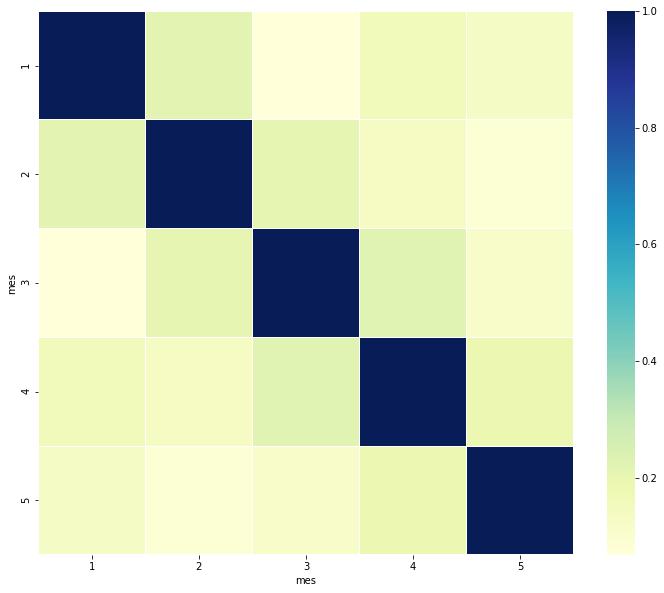

In [117]:

corrmat = datos_tiempo.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

In [118]:
j = 0
for i in datos_tiempo.columns:
    datos_tiempo.rename(columns={j:'prom_tiempo_'+str(j)},inplace=True)
    j =  j + 1

In [119]:
datos_tiempo.fillna(0,inplace=True)

In [120]:
compras = datos.loc[datos['event'] == 'conversion',['person','mes','timestamp']]
compras = compras.groupby(['person','mes']).count()

compras = compras.unstack().fillna(0)
compras.columns = compras.columns.droplevel(0)

j = 1
for i in compras.columns:
    compras.rename(columns={j:'compras_'+str(j)},inplace=True)
    j =  j + 1

In [104]:
#for i in compras_por_q:
#    compras.loc[compras[i]>0,i] = 1
#compras

In [121]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index(level=0,drop=False)
eventos_x_person.fillna(0,inplace=True)

In [122]:
train = pd.read_csv("labels_training_set.csv",low_memory=False)

In [123]:
dat = pd.merge(compras,datos_tiempo,on='person')
train = pd.merge(train,dat,on='person')

In [124]:
train = pd.merge(train,eventos_x_person,on='person')

In [125]:
features = train.iloc[:,2:].columns

In [126]:
from sklearn.model_selection import train_test_split

test_s = 0.20
random_s = 0

x = np.array(train[train.iloc[:,2:].columns])
y = np.array(train['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_s, random_state=random_s)

In [127]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

print('VALORES INICIALES PARA K')

k_valores = [5,7,10,20,50]
mejor_k = 0
mejor_precision = 0

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(np.array(y_test), pred)
    print('La precisión para k=', k, 'es:',precision)
    if precision > mejor_precision:
        mejor_precision = precision
        mejor_k = k
        
print('Con k=', mejor_k, 'se obtuvo la mayor precisión:', mejor_precision)

VALORES INICIALES PARA K
La precisión para k= 5 es: 0.5187208527648234
La precisión para k= 7 es: 0.4962025316455696
La precisión para k= 10 es: 0.5
La precisión para k= 20 es: 0.5
La precisión para k= 50 es: 0.5
Con k= 5 se obtuvo la mayor precisión: 0.5187208527648234


In [128]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train.iloc[:,2:],train['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [129]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    print('"' + name + '"'+" : ",importance,',')

"compras_1" :  0.004663555102461646 ,
"compras_2" :  0.0030751278284910076 ,
"compras_3" :  0.01880526887349649 ,
"compras_4" :  0.011588653923926774 ,
"compras_5" :  0.05302804521279802 ,
"prom_tiempo_1" :  0.014197164483843401 ,
"prom_tiempo_2" :  0.013353259587674906 ,
"prom_tiempo_3" :  0.02864244491723424 ,
"prom_tiempo_4" :  0.048455508876188436 ,
"prom_tiempo_5" :  0.14391942895907492 ,
"ad campaign hit" :  0.06987898730000756 ,
"brand listing" :  0.07661804683567573 ,
"checkout" :  0.06433466127513733 ,
"conversion" :  0.0314763475324362 ,
"generic listing" :  0.08302472237736688 ,
"lead" :  0.008353381775315895 ,
"search engine hit" :  0.06189898732828197 ,
"searched products" :  0.05821302697081557 ,
"staticpage" :  0.03158607466625108 ,
"viewed product" :  0.10066915926621106 ,
"visited site" :  0.0742181469073108 ,
